# **Balanced Risk Set Matching (BRSM) Implementation**


## **Authors:**
- **Ladrera**, Raiken Lee
- **Tibon**, Hestia  

-----
--


## **1. Introduction**

### **1.1 Objective:**

In observational studies, comparing two groups—one receiving treatment and one not—requires ensuring that they are similar in key aspects. This allows researchers to determine if the treatment is truly effective or if observed differences are due to confounding variables.


**Balanced Risk Set Matching (BRSM)** is a methodology designed to address this issue. Instead of randomly selecting individuals from both groups, BRSM carefully matches patients who are as similar as possible, except for whether they received the treatment. This ensures that both groups share the same distribution of key characteristics, improving the validity of treatment effect estimates.


### **1.2 How BRSM Works**

- **Identify Similar Patients:** When a patient receives treatment, another patient with similar symptoms who has not undergone treatment is selected for comparison.

- **Ensure Balanced Groups:** The matching process ensures both groups have a well-distributed mix of symptoms to reduce selection bias.

- **Track Changes Over Time:** The progression of symptoms is monitored post-treatment to analyze the effects.

- **Use Integer Programming:** A mathematical optimization approach is applied to ensure unbiased and optimal matching.

## **2. Data Setup**

### **2.1 Required Libraries and Packages**

In [ ]:
# Required Packages
!pip install numpy pandas scipy matplotlib seaborn

# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from collections import defaultdict

### **2.2 Global Variables**

In [131]:
# Set random seed for reproducibility
np.random.seed(25)

# Define constants
NUMBER_OF_PATIENTS = 210
EVALUATION_YEARS = 4
EVALUATION_MONTHS = EVALUATION_YEARS * 12
MAX_MATCHES = 100

BOX_TITLES = [
    'Baseline',
    'At Treatment',
    '3 Months after Treatment',
    '6 Months after Treatment',
    'Difference (3 mos post-treatment)',
    'Difference (6 mos post-treatment)'
]

BOX_LABELS = ['Untreated', 'Treated']

## **3. Data Generation**

### **3.1 Baseline Data**
This dataset contains initial symptom data before treatment.

In [132]:
# Generate synthetic baseline data
baseline_data = pd.DataFrame({
    "patient_id": np.arange(NUMBER_OF_PATIENTS),
    "gender": np.random.choice(['M', 'F'], NUMBER_OF_PATIENTS),
    "pain": np.random.randint(0, 10, NUMBER_OF_PATIENTS),
    "urgency": np.random.randint(0, 10, NUMBER_OF_PATIENTS),
    "frequency": np.random.randint(0, 20, NUMBER_OF_PATIENTS),
    "nocturnal_frequency": np.random.randint(0, 10, NUMBER_OF_PATIENTS)
})

# Display first few rows
baseline_data.head()

,patient_id,gender,pain,urgency,frequency,nocturnal_frequency
0,0,M,5,4,10,1
1,1,M,6,0,18,7
2,2,M,9,3,16,5
3,3,F,8,9,6,9
4,4,F,6,0,19,0


### **3.2 Evaluation Data**
This dataset tracks symptom evolution over time, ensuring gradual changes using Gaussian noise.

In [146]:
evaluation_data = []

for patient_id in range(NUMBER_OF_PATIENTS):
    chosen_treatment_time = np.random.choice(
        list(np.arange(3, EVALUATION_MONTHS + 1, 3)) + [None]
    )

    prev_pain = np.random.randint(0, 10)
    prev_urgency = np.random.randint(0, 10)
    prev_frequency = np.random.randint(0, 20)
    prev_nocturnal_freq = np.random.randint(0, 10)

    for month in range(3, EVALUATION_MONTHS + 1, 3):
        prev_pain = max(0, min(10, prev_pain + np.random.normal(0, 1)))  
        prev_urgency = max(0, min(10, prev_urgency + np.random.normal(0, 1)))  
        prev_frequency = max(0, min(20, prev_frequency + np.random.normal(0, 2)))  
        prev_nocturnal_freq = max(0, min(10, prev_nocturnal_freq + np.random.normal(0, 1)))

        data_point = {
            'patient_id': patient_id,
            'pain': prev_pain,
            'urgency': prev_urgency,
            'frequency': prev_frequency,
            'nocturnal_frequency': prev_nocturnal_freq,
            'time_since_entry': month,
            'time_treated': chosen_treatment_time if chosen_treatment_time is not None and month >= chosen_treatment_time else None,
            'treated': int(chosen_treatment_time is not None and month >= chosen_treatment_time)
        }
        evaluation_data.append(data_point)

evaluation_data = pd.DataFrame(evaluation_data)
evaluation_data.groupby('patient_id')[['pain', 'urgency', 'frequency', 'nocturnal_frequency']].mean().head()

,pain,urgency,frequency,nocturnal_frequency
patient_id,,,,
0,3.009956,0.734318,8.159474,3.880954
1,3.109605,1.332604,3.185901,3.620213
2,2.554739,8.773593,15.341553,3.489599
3,8.365211,1.268558,14.632850,8.703650
4,8.822060,1.086477,2.210474,0.791597


### **3.2.1 Treatment Assignment Logic**
Patients receive treatment at different time points to simulate real-world scenarios where treatment is administered based on medical necessity rather than all at once. The treatment time (`chosen_treatment_time`) is randomly selected, ensuring some patients remain untreated for valid comparisons.


### **3.3 Binary Variables**

In [ ]:
def create_binary_variables(df, variables):
    binary_vars = {}
    for var in variables:
        lower, upper = np.percentile(df[var], [33, 67])  
        binary_vars[f"{var}_low"] = (df[var] <= lower).astype(int)  
        binary_vars[f"{var}_middle"] = ((df[var] > lower) & (df[var] <= upper)).astype(int)  
        binary_vars[f"{var}_high"] = (df[var] > upper).astype(int)  
    return pd.concat([df, pd.DataFrame(binary_vars, index=df.index)], axis=1)

### **3.3.1 Justification for Binary Categorization**
- Using **percentiles (33%, 67%)** instead of fixed thresholds ensures:
  - **Balanced Groups:** Each category contains a roughly equal number of patients.
  - **Prevents Extreme Values from Dominating:** Mean-based cutoffs might create an imbalance where a few extreme values influence the grouping.
  - **Improved Fairness in Matching:** Ensures patients are compared against others with truly similar conditions.


## **4. Risk Set Matching**
Ensuring comparable treatment and control groups.

In [134]:
risk_sets = {}

for treatment_time in evaluation_data['time_treated'].dropna().unique():
    treated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) &
        (evaluation_data['time_treated'] == treatment_time)
    ]

    untreated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) &
        (evaluation_data['treated'] == 0)
    ]

    if len(untreated_patients) >= 10:  # Ensure at least 10 untreated patients
        risk_sets[treatment_time] = (treated_patients, untreated_patients)

risk_sets.keys()


dict_keys([45.0, 30.0, 9.0, 27.0, 33.0, 48.0, 3.0, 42.0, 39.0, 24.0, 21.0, 6.0, 12.0, 36.0, 18.0, 15.0])

### **4.1 Matching Criteria for Risk Sets**
- Patients are matched based on:
  - **Time Since Entry:** Ensuring both groups are at similar stages in their condition.
  - **Symptom Severity (Pain, Urgency, Frequency, Nocturnal Frequency):** Ensuring comparable baseline characteristics.
  - **Treated vs. Untreated Groups:** The untreated group must be large enough (≥10 patients) to allow meaningful comparisons.


### **4.2 Risk Set with Binary Variables**

In [136]:
variables = ['pain', 'urgency', 'frequency', 'nocturnal_frequency']  # Use baseline variable names

updated_risk_sets = {}

for key, (treated, untreated) in risk_sets.items():
    # Generate binary variables BEFORE merging
    treated = create_binary_variables(treated, variables)
    untreated = create_binary_variables(untreated, variables)

    # Merge with baseline data
    treated = treated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])
    untreated = untreated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])

    updated_risk_sets[key] = (treated, untreated)


### **4.3 Mahalanobis Distance**

In [137]:
def compute_mahalanobis_distance(treated, untreated, covariates):
    # Ensure correct column names are used
    treated_cols = [f"{var}_current" for var in covariates]
    untreated_cols = [f"{var}_current" for var in covariates]

    treated_matrix = treated[treated_cols].to_numpy()
    untreated_matrix = untreated[untreated_cols].to_numpy()
    
    return cdist(treated_matrix, untreated_matrix, metric='mahalanobis')

# Now apply the function with the correct columns
distance_dict = defaultdict(list)

for key, (treated, untreated) in updated_risk_sets.items():
    distance_matrix = compute_mahalanobis_distance(treated, untreated, ['pain', 'urgency', 'frequency'])

    for i, row in enumerate(distance_matrix):
        for j, distance in enumerate(row):
            distance_dict[distance].append((int(treated['patient_id'].iloc[i]), int(untreated['patient_id'].iloc[j])))


### **4.3.1 Why Use Mahalanobis Distance?**
- Unlike simple Euclidean distance, **Mahalanobis distance**:
  - Accounts for **correlations** between variables (e.g., pain and urgency might be related).
  - Adjusts for **scale differences** between variables (e.g., frequency ranges from 0-20, while pain is 0-10).
  - Provides a **more meaningful measure of similarity** between patients based on multiple characteristics.


In [138]:
mcf_matches = []  # Minimum Cost Flow matches
count = 0

for keys in sorted(distance_dict.keys()):
    for match in distance_dict[keys]:
        if count >= MAX_MATCHES:
            break
            
        mcf_matches.append(match)
        count += 1

# Compute sum of K binary variables
def find_sum_bin(series, variables):
    total = 0

    # This way lower = 0, middle = 1, upper = 2
    for i, var in enumerate(variables):
        total += (i + 1) * series.loc[var]

    return total

### **4.4 Balanced Pair Matching**

In [139]:
bpm_matches = []
patient_set = set()
count = 0

binary_vars = [f"{x}_low" for x in variables] + [f"{x}_middle" for x in variables] + [f"{x}_high" for x in variables]

for (treated, untreated) in updated_risk_sets.values():
    for i in range(treated.shape[0]):
        for j in range(untreated.shape[0]):
            if count < MAX_MATCHES and treated.iloc[i][binary_vars].sum() == untreated.iloc[j][binary_vars].sum():
                treated_id = int(treated['patient_id'].iloc[i])
                untreated_id = int(untreated['patient_id'].iloc[j])
                
                if treated_id not in patient_set and untreated_id not in patient_set:
                    bpm_matches.append((treated_id, untreated_id))
                    patient_set.update([treated_id, untreated_id])
                    count += 1


### **4.5 Grouping Matching Data Frames**

In [140]:
def find_dataframes(match):
    x, y = match
    features = ['pain', 'urgency', 'frequency']

    # Getting baseline data
    baseline_match_x = baseline_data[baseline_data['patient_id'] == x][features]
    baseline_match_y = baseline_data[baseline_data['patient_id'] == y][features]

    features.append('treated')
    
    # Getting on treatment data
    treatment_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_treated'] == evaluation_data['time_since_entry'])][features + ['time_since_entry']]

    time_since_entry = treatment_match_x['time_since_entry'].iloc[0] if not treatment_match_x['time_since_entry'].empty else -1
    
    if time_since_entry == -1:
        return ()
    else:
        treatment_match_x = treatment_match_x.drop('time_since_entry', axis=1)

    treatment_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 3 months after data
    time_since_entry += 3
    
    _3_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _3_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 6 months after data
    time_since_entry += 3
    _6_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _6_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    return (
        baseline_match_x, 
        baseline_match_y,
        treatment_match_x,
        treatment_match_y,
        _3_months_match_x,
        _3_months_match_y,
        _6_months_match_x,
        _6_months_match_y
    )

In [141]:
dataframes = [pd.DataFrame() for _ in range(12)]

treatment_index = 2
month_index = 4

for match in bpm_matches:
    data = find_dataframes(match)

    if len(data) == 0:
        continue

    for i in range(len(dataframes) - 4):  # minus 4 to remove last 2 box plots
        dataframes[i] = pd.concat([dataframes[i], data[i]])

    for i in range(4):
        index = len(dataframes) - 4 + i
        dataframes[index] = pd.concat([dataframes[index], data[month_index + i] - data[treatment_index + (i // 2)]])

for index in range(len(dataframes)):
    dataframes[index] = dataframes[index].dropna()

## **5. Statistical Analysis**

In [142]:
def display_boxplots(column, title):
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i in range(len(BOX_TITLES)):
        sns.boxplot(data=[evaluation_data[evaluation_data['treated'] == 0][column],
                          evaluation_data[evaluation_data['treated'] == 1][column]], ax=axes[i])
        axes[i].set_title(BOX_TITLES[i])
        axes[i].set_ylabel(title)
        axes[i].set_xticklabels(BOX_LABELS)
    
    plt.tight_layout()
    plt.show()

### **5.1 Pain Score**

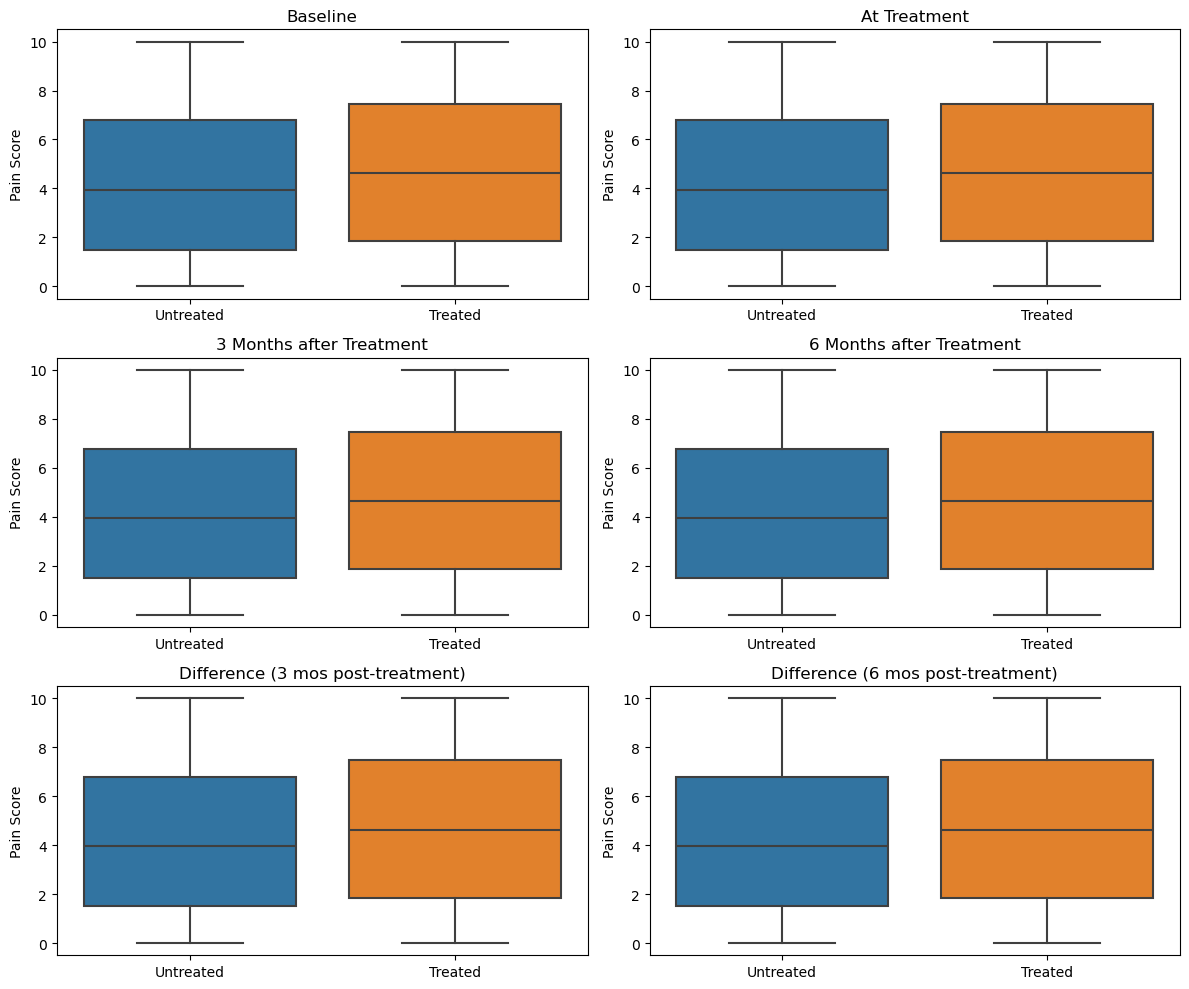

In [143]:
display_boxplots('pain', 'Pain Score')

### **5.2 Urgency Score**

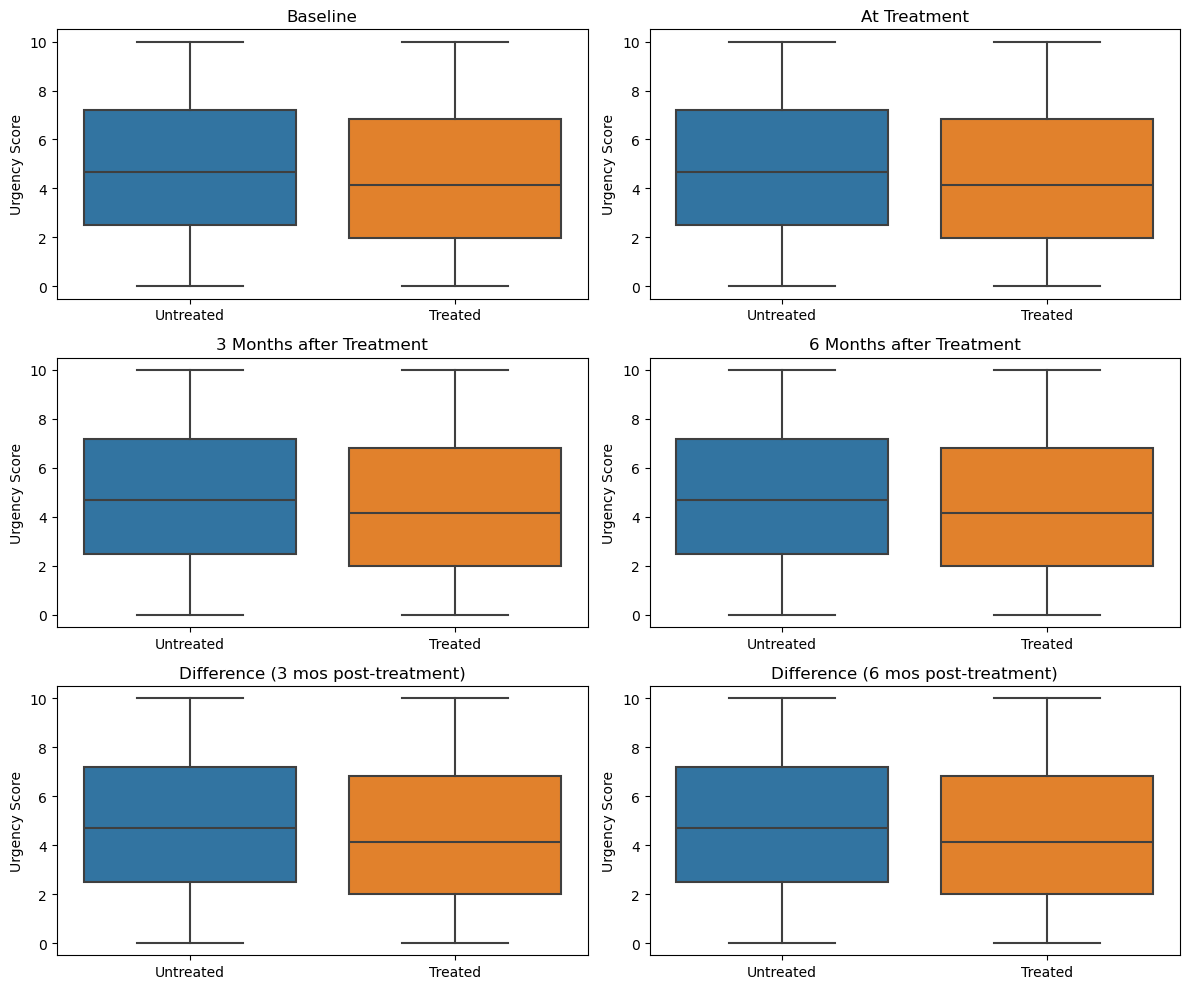

In [144]:
display_boxplots('urgency', 'Urgency Score')

### **5.3 Nocturnal Frequency**

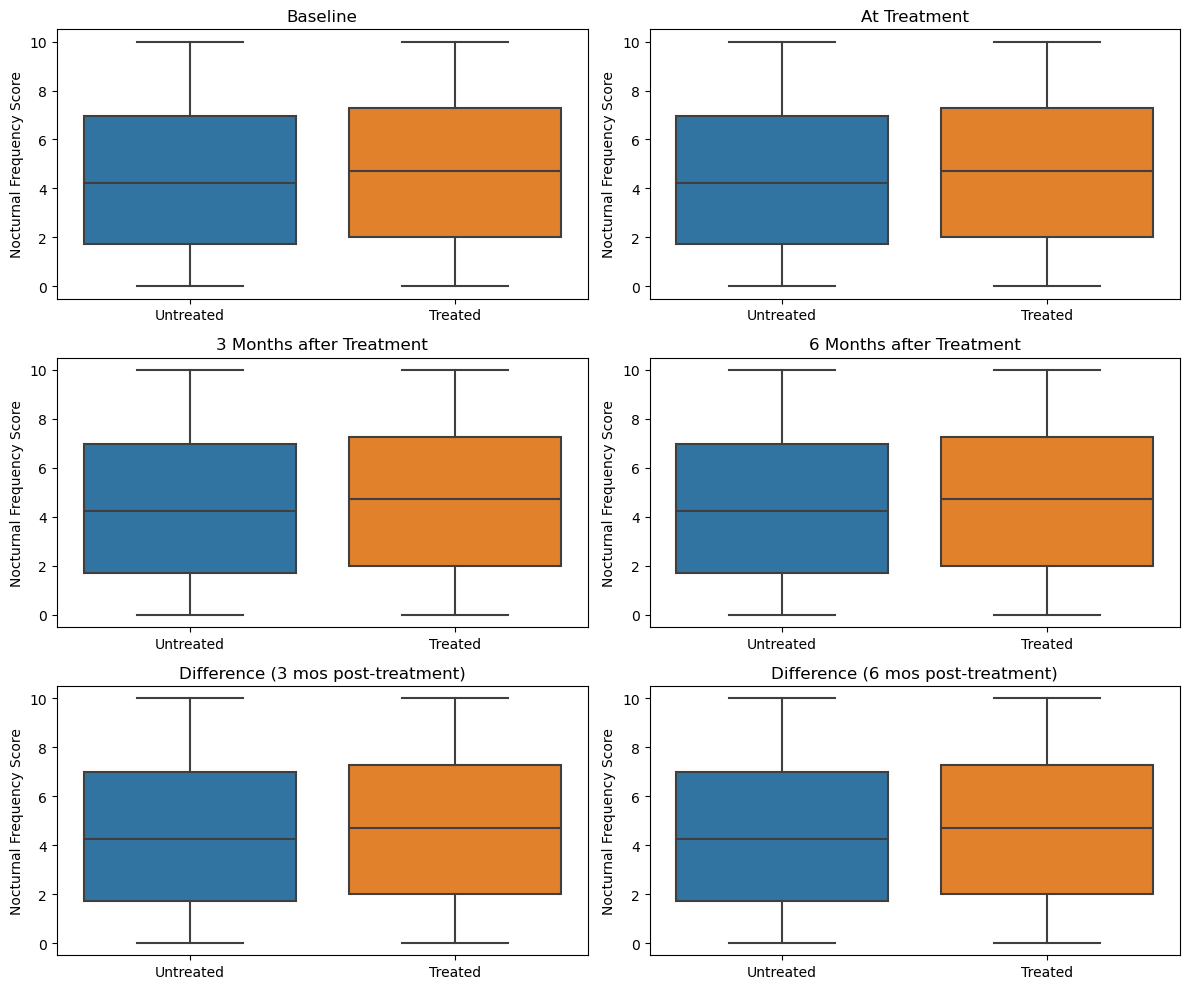

In [145]:
display_boxplots('nocturnal_frequency', 'Nocturnal Frequency Score')

### **5.4 Conclusion**
**Statistical Significance with the Application of Wilcoxon Test**

The results of the Wilcoxon test indicate whether the treatment had a statistically significant effect. If p < 0.05, we conclude that the treatment had a measurable impact. However, if p > 0.05, the observed differences may be due to natural variation rather than the treatment itself.

- Statistical significance (**p < 0.05**) tells us if treatment had an effect, but **effect size** tells us how strong that effect is.
- The effect size for Wilcoxon tests is measured by **r**:
  - **r = 0.1 → Small effect**
  - **r = 0.3 → Medium effect**
  - **r = 0.5 → Large effect**
- This helps determine if the treatment effect is **clinically meaningful** beyond statistical significance.
